In [271]:
import numpy as np
from matplotlib import pyplot as plt
import drehung

In [272]:
SAMPLE_SIZE=40

VOLUME_SAMPLE=int(5e4)

In [273]:
sample_random=[]
while len(sample_random)<SAMPLE_SIZE:
    sample_new=np.ones((4,4))-2*np.random.random((4,4))
    if not all([np.linalg.norm(i)<1 for i in sample_new]):
        continue
    sample_random.append([i/np.linalg.norm(i) for i in sample_new])

In [274]:
def make_tetraeder(winkel):
    a = np.cos(winkel)
    b_2 = np.sqrt(1 - a**2)
    b_3_4 = (a - a**2)/b_2
    c_3 = np.sqrt(1 - a**2 - b_3_4**2)
    c_4 = (a - a**2 - b_3_4**2) / c_3
    d_4 = np.sqrt(1 - a**2 - b_3_4**2 - c_4**2 )

    normal_vectors= [np.array([1,0,0,0]), np.array([a, b_2, 0,0]), np.array([a, b_3_4, c_3,0 ]), np.array([a, b_3_4, c_4, d_4])]
    
def tetrahedron(x):
    fac=np.sqrt(1-x**2)
    return np.array([[np.sqrt(8/9)*fac,0,-fac/3,x],
                    [-np.sqrt(2/9)*fac,fac*np.sqrt(2/3),-fac/3,x],
                    [-np.sqrt(2/9)*fac,-fac*np.sqrt(2/3),-fac/3,x],
                    [0,0,fac,x]])
def pointiness(tetra):
    pointiness=8*np.pi
    for p1 in range(4):
        for p2 in range(4):
            if p1==p2:
                continue
            p3=(p2+1)%4
            if p3==p1:
                p3=(p3+1)%4
            vec1=tetra[p2]-tetra[p1]*(tetra[p2]@tetra[p1])
            vec1/=np.linalg.norm(vec1)
            vec2=tetra[p3]-tetra[p1]*(tetra[p3]@tetra[p1])
            vec2/=np.linalg.norm(vec2)
            angle=np.acos(vec1@vec2)
            pointiness-=angle
    return pointiness



In [137]:
tetra=np.array([[1,0,0,0],
                [0,0,1,0],
                [0,1,0,0],
                [-np.sqrt(2)/2,-np.sqrt(2)/2,0,0]])
for p in tetra[1:]:
    print(p-tetra[0]*(p@tetra[0]))
pointiness(tetra)

[0. 0. 1. 0.]
[0. 1. 0. 0.]
[ 0.         -0.70710678  0.          0.        ]


np.float64(0.0)

In [162]:
x_sample=[0.1,0.01,0.001]
volumes=[]
pointinesses=[]
for x in x_sample:
    tetra=tetrahedron(x)

    pointsIn=0
        
    for _ in range(VOLUME_SAMPLE):
        point=np.ones((1,4))
        while np.linalg.norm(point)>1:
            point=np.ones((1,4))-2*np.random.random((1,4))
        point/=np.linalg.norm(point)
        inside=True
        for i in range(len(tetra)):
            vecs=np.copy(tetra)
            
            a=np.copy(vecs[3])
            vecs[3]=np.copy(vecs[i])
            vecs[i]=a
        
            vecs=drehung.orthonormalisierung(vecs)
        
            if(point@vecs[3]<0):
                inside=False
                break
        pointsIn+=inside
    volumes.append(pointsIn/VOLUME_SAMPLE)
    pointinesses.append(pointiness(tetra))

In [275]:
volumes_random=[]
pointinesses_random=[]
for tetra in sample_random:
    pointsIn=0
    
    for _ in range(VOLUME_SAMPLE):
        point=np.ones((1,4))
        while np.linalg.norm(point)>1:
            point=np.ones((1,4))-2*np.random.random((1,4))
        point/=np.linalg.norm(point)
        inside=True
        for i in range(len(tetra)):
            vecs=np.copy(tetra)
            a=np.copy(vecs[3])
            vecs[3]=np.copy(vecs[i])
            vecs[i]=a
            vecs=drehung.orthonormalisierung(vecs)
            if(point@vecs[3]<0):
                inside=False
                break
        pointsIn+=inside
    volume=pointsIn/VOLUME_SAMPLE
    volumes_random.append(volume)
    pointinesses_random.append(pointiness(tetra))


In [38]:
point=np.ones((1,4))
while np.linalg.norm(point)>1:
    point=np.ones((1,4))-2*np.random.random((1,4))
point

array([[ 0.12308642,  0.39914314,  0.66365056, -0.33776301]])

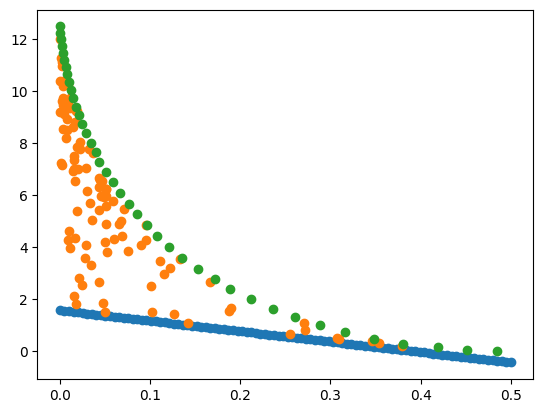

In [161]:
plt.scatter(np.linspace(0,0.5,100),[np.pi/2-4*x for x in np.linspace(0,0.5,100)])
plt.scatter(volumes_random,pointinesses_random)

plt.scatter(volumes,pointinesses)

In [182]:
indices=[]
for i in range(100):
    if pointinesses_random[i]<=0.3+np.pi/2-4*(volumes_random[i]):
        indices.append(i)

In [186]:
for i in range(1,4):
    for j in range(i):
        print(np.linalg.norm(sample_random[22][i]-sample_random[22][j]))

0.7860744091910968
1.8629812637102579
1.7917434270332404
1.4619383431629387
1.833397183804176
1.5126680029091708


In [192]:
basis=drehung.orthonormalisierung([(x-sample_random[22][0]) for x in sample_random[22][1:]])

2 0.015192368761790163 0.04184712266061888
4 0.04482542979242003 0.01263309363339438
15 0.060104428937931276 0.00631654681669719
18 0.01655886661313144 0.20489298736661507
28 0.11537293409156338 0.019344424626135143
32 0.0015977040552614744 0.02013399297822229


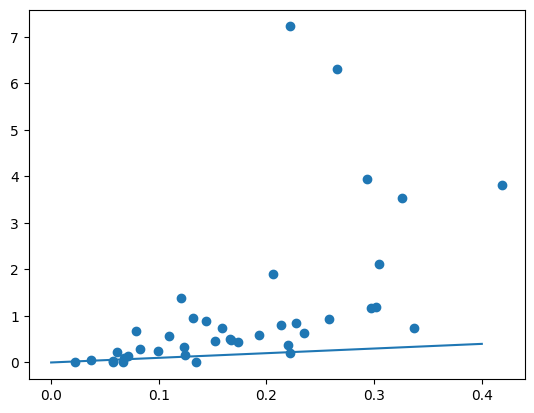

In [276]:
to_be_plotted=[]
for (i,tetra) in enumerate(sample_random):
    volume_sphere=2*np.pi**2*volumes_random[i]
    volume_euclidean=abs(np.linalg.det((drehung.orthonormalisierung([(x-tetra[0]) for x in tetra[1:]])@np.array([x-tetra[0] for x in tetra[1:]]).T).T))/6
    if(volume_euclidean>volume_sphere):
        print(i,volume_euclidean-volume_sphere,volume_sphere)
    to_be_plotted.append(volume_euclidean)
plt.scatter(to_be_plotted,np.array(volumes_random)*2*np.pi**2)
plt.plot(np.linspace(0,0.4,10000),np.linspace(0,0.4,10000))

In [270]:
tetra=sample_random[78]
pointsIn=0
    
for _ in range(int(1e6)):
    point=np.ones((1,4))
    while np.linalg.norm(point)>1:
        point=np.ones((1,4))-2*np.random.random((1,4))
    point/=np.linalg.norm(point)
    inside=True
    for i in range(len(tetra)):
        vecs=np.copy(tetra)
        a=np.copy(vecs[3])
        vecs[3]=np.copy(vecs[i])
        vecs[i]=a
        vecs=drehung.orthonormalisierung(vecs)
        if(point@vecs[3]<0):
            inside=False
            break
    pointsIn+=inside
pointsIn/1e6*np.pi**2*2

[[-0.26079676  0.48520429 -0.83264873  0.0570784 ]
 [-0.42262076  0.42302405  0.80102166  0.02840158]
 [ 0.86835013 -0.34165189  0.20658712 -0.29421726]
 [ 0.4959899   0.81971395 -0.13949995 -0.25020556]]
[[ 0.4959899   0.81971395 -0.13949995 -0.25020556]
 [-0.42262076  0.42302405  0.80102166  0.02840158]
 [ 0.86835013 -0.34165189  0.20658712 -0.29421726]
 [-0.26079676  0.48520429 -0.83264873  0.0570784 ]]


0.0

In [265]:
tetra=sample_random[78]

In [266]:
basis=drehung.orthonormalisierung([(x-tetra[0]) for x in tetra[1:]])
tetra_3d=(drehung.orthonormalisierung([(x-tetra[0]) for x in tetra[1:]])@np.array([x-tetra[0] for x in tetra[1:]]).T).T

In [268]:
tetra_3d

array([[ 1.64309302e+00,  2.27012589e-17, -1.60473187e-17],
       [ 9.59491576e-01,  1.49715048e+00, -1.07128255e-16],
       [ 6.07343836e-01,  5.50033693e-01,  7.66875361e-01]])